<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/LSTM_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of the Problem:
In this task, we aim to detect anomalous high-pitch signals in a sound wave and eliminate them. We will use RNNs (or LSTM, which is a more advanced form of RNN) to handle this, as they are great at working with sequential data like audio signals.

# Steps to Implement:
Generate or load the audio dataset: For simplicity, let's simulate a signal with high-pitched anomalies using sine waves.

Preprocess the audio data: We'll convert audio signals into a form that RNNs can process, typically spectrograms or time-series data.

# Build an RNN model:
We'll use LSTM (Long Short-Term Memory) as the recurrent layer to detect anomalies.

Train the model: We will train the model to identify normal and anomalous sound patterns.

Detect and eliminate anomalies: The model will predict the presence of anomalies and filter them out.

# Step 1: Simulating Audio Data with Anomalous High Pitch Signals

For this example, we'll simulate the data. The "normal" sound is a simple sine wave, and the anomaly is a high-pitched sine wave that appears at random intervals.

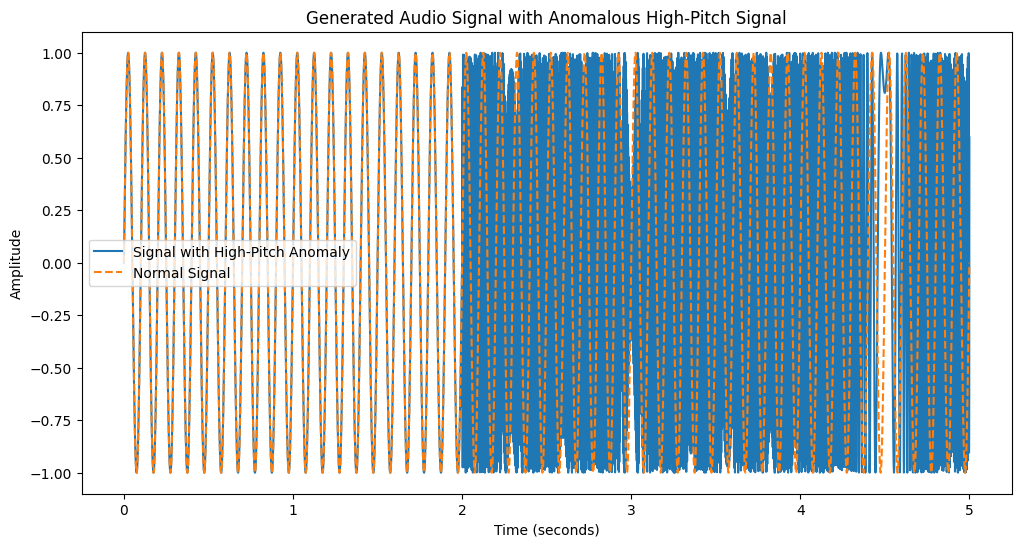

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

# Generate normal sound wave (sine wave)
sampling_rate = 1000  # Sampling rate in Hz (samples per second)
t = np.linspace(0, 5, sampling_rate * 5)  # Time from 0 to 5 seconds
normal_signal = np.sin(2 * np.pi * 10 * t)  # 10 Hz sine wave (normal)

# Generate anomalous high-pitch signal (chirp signal with high frequency)
anomaly_duration = 1  # duration in seconds for the anomaly
anomaly_start = 2  # time at which anomaly starts

# High-pitch chirp signal (frequency increases with time)
anomaly_signal = chirp(t[t > anomaly_start], f0=100, f1=500, t1=anomaly_start + anomaly_duration, method='quadratic')

# Combine normal signal and anomaly
signal_with_anomaly = normal_signal.copy()
signal_with_anomaly[t > anomaly_start] = anomaly_signal  # Inject anomaly into the normal signal

# Plot the signal with the anomaly
plt.figure(figsize=(12, 6))
plt.plot(t, signal_with_anomaly, label="Signal with High-Pitch Anomaly")
plt.plot(t, normal_signal, label="Normal Signal", linestyle='--')
plt.legend()
plt.title("Generated Audio Signal with Anomalous High-Pitch Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


# Explanation:
Normal Signal: We use a 10 Hz sine wave to simulate a normal sound wave.

# Anomalous High Pitch:

The chirp signal (which is a sine wave with increasing frequency) represents the high-pitched anomaly. It appears at a random time and lasts for a short duration.

The plot shows the normal signal (dashed) and the signal with the anomaly (solid).

# Step 2: Preprocess the Signal Data for RNN

Now that we have the signal data, we need to preprocess it to feed it into the RNN. We'll normalize the signal and reshape it to match the expected input format for RNNs.

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Reshape the signal to be in the shape (samples, timesteps, features)
scaler = MinMaxScaler(feature_range=(0, 1))
signal_normalized = scaler.fit_transform(signal_with_anomaly.reshape(-1, 1))

# Create sliding windows to form input-output pairs for training
def create_dataset(data, window_size=100):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])  # Next value prediction
    return np.array(X), np.array(y)

window_size = 100
X, y = create_dataset(signal_normalized, window_size=window_size)

# Reshape X to match the LSTM input shape (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


# Explanation:

Normalization: The data is normalized to the range [0, 1] using MinMaxScaler. This helps the neural network learn more effectively.

Sliding Window: We create sequences of window_size length from the signal to train the model. Each sequence will be used to predict the next value in the sequence.

# Step 3: Build the LSTM Model for Anomaly Detection

We'll now build an LSTM-based model to detect anomalies.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1), return_sequences=False))  # LSTM layer
model.add(Dense(32, activation='relu'))  # Dense layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (1 for anomaly detection)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

# Explanation:
# LSTM Layer:

The LSTM layer is the core of the model. We use 64 neurons and ReLU activation. The model reads sequences of sound data and outputs whether a given time point is part of the normal sound or an anomaly.

# Dense Layers:

After the LSTM, we have a Dense layer with 32 neurons and a final output layer with 1 neuron (sigmoid activation) for binary classification (normal or anomalous).

# Loss Function:

 Since we are doing binary classification (normal vs. anomalous), we use binary cross-entropy as the loss function.

# Step 4: Train the Model

We will train the model using the input sequences (X) and target labels (y).

In [4]:
# Train the model
model.fit(X, y, epochs=10, batch_size=32)


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.0000e+00 - loss: 691.5261
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 1.2781e-04 - loss: 0.7522
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 2.6154e-04 - loss: 0.6373
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 2.0475e-05 - loss: 0.6186
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 1.6827e-04 - loss: 0.6224
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.0000e+00 - loss: 0.6143
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 4.1637e-05 - loss: 0.6103
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.0000e+00 - loss: 0.6027
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.0000e+00 - loss: 0.5974
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.0000e+00 - loss: 0.6423


Explanation:
We train the model for 10 epochs using a batch size of 32. The model learns the patterns in the signal and distinguishes between normal and anomalous parts.

# Step 5: Anomaly Detection and Elimination
Now that the model is trained, we will use it to predict and detect anomalies in the signal.

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


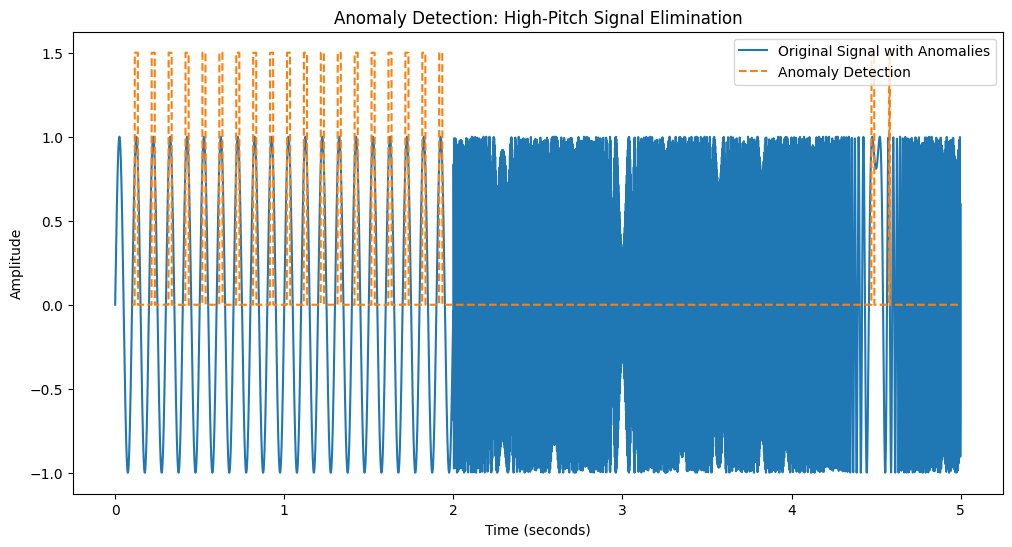

In [5]:
# Predict on the entire signal
predictions = model.predict(X)

# Convert predictions to binary (normal=0, anomaly=1)
anomalies = (predictions > 0.5).astype(int)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, signal_with_anomaly, label="Original Signal with Anomalies")
plt.plot(t[window_size:], anomalies * 1.5, label="Anomaly Detection", linestyle='--')
plt.legend()
plt.title("Anomaly Detection: High-Pitch Signal Elimination")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


# Explanation:

# Prediction:

 We use the trained model to predict the "normal" vs "anomalous" parts of the signal.

# Thresholding:

 We classify predictions greater than 0.5 as anomalies (since we're using sigmoid activation).

# Plot:

We plot the original signal with anomalies and the predicted anomalies.

Final Thoughts:
This code simulates a high-pitch anomaly detection task using LSTM in a sound wave signal.

The LSTM model learns to distinguish between normal sound and anomalous high-pitch signals.

You can extend this approach to real-world tasks by using actual audio data, preprocessing it into spectrograms or time-series, and then applying anomaly detection.